In [15]:
import torch 
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

import pandas as pd

import os, sys
sys.path.append(os.path.abspath(".."))

from config import PROJECT_ROOT, DATA_DIR, SCRIPTS_DIR, CSV_PATH

from bitcoin.data import BitcoinDataset
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Modelling Historical Bitcoin Price using a Multi-layer minGRU

### Read in Historical Data

In [2]:
btcusd = BitcoinDataset(csv_path=CSV_PATH, update=False)
btcusd.df.head()

,Datetime,Close
0,2012-01-01 10:01:00,4.58
1,2012-01-01 10:02:00,4.58
2,2012-01-01 10:03:00,4.58
3,2012-01-01 10:04:00,4.58
4,2012-01-01 10:05:00,4.58


In [ ]:
# Scale data
btcusd_scaled = btcusd.scaled_data
(X_train, y_train), _, (X_test, y_test) = btcusd.train_test_split(train_ratio=0.9)

Creating train/test splits using window size of 100...


100%|██████████| 7011376/7011376 [00:41<00:00, 167340.24it/s]


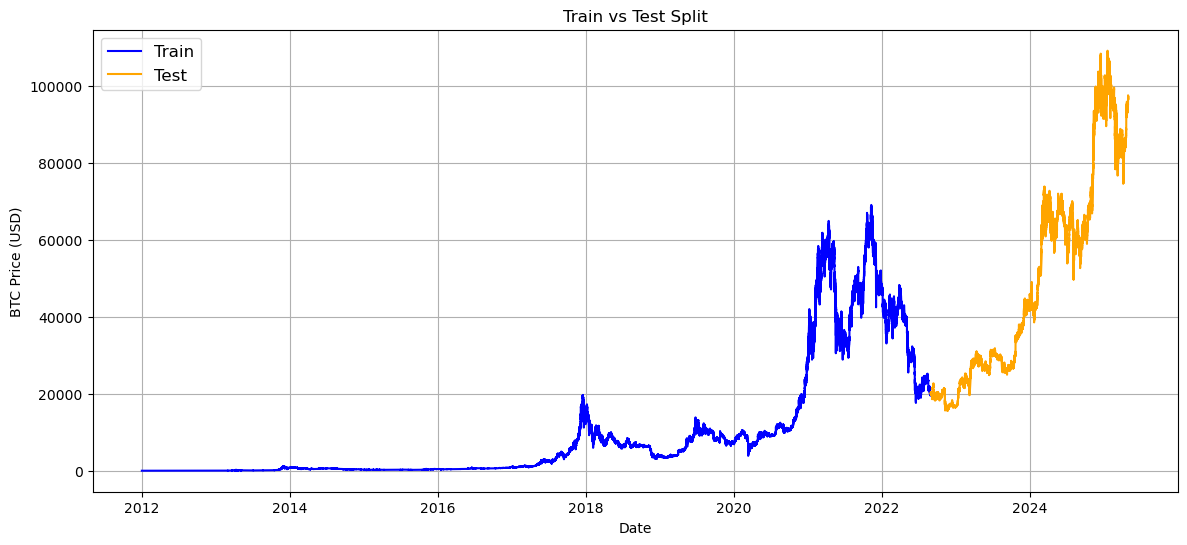

In [26]:

# Recover the full datetime series (excluding the initial window offset)
timestamps = btcusd.df["Datetime"].iloc[btcusd.window_size:].reset_index(drop=True)
prices = btcusd.scaler.inverse_transform(btcusd.scaled_data.numpy()).squeeze()

# Calculate how many points are in each split
n_train = len(X_train)
n_test = len(X_test)

# Plot
plt.figure(figsize=(14, 6))
plt.plot(timestamps[:n_train], prices[btcusd.window_size:btcusd.window_size + n_train], label="Train", color='blue')
plt.plot(timestamps[-n_test:], prices[-n_test:], label="Test", color='orange')
plt.xlabel("Date")
plt.ylabel("BTC Price (USD)")
plt.title("Train vs Test Split")
plt.legend( fontsize='large' )
plt.grid(True)
plt.show()


In [8]:
# X_train = X_train.squeeze(-1)
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)

X_train:  torch.Size([5609100, 100, 1])
y_train:  torch.Size([5609100])


In [12]:
train_batch_size = 128
train_dataset = TensorDataset(X_train, y_train)
train_dl = DataLoader(train_dataset, batch_size=128, shuffle=True)

for X, y in train_dl:
    print(X.shape)
    print(y.shape)
    break

torch.Size([128, 100, 1])
torch.Size([128])


In [ ]:
class MinGRU(nn.Module):
    def __init__(self, in_dim=1, hidden_dim=16, out_dim=1):
        super().__init__()
        self.in_dim = in_dim
        self.hidden_dim = hidden_dim
        self.out_dim = out_dim
        self.h = None
        
        # Update gate
        self.update_gate = nn.Sequential(
            nn.Linear(self.in_dim, self.hidden_dim),
            nn.Sigmoid()
        )
        
        # Candidate hidden state
        self.candidate_h_layer = nn.Linear(self.in_dim, self.hidden_dim)
        
        # Final output
        self.output_layer = nn.Linear(self.hidden_dim, self.out_dim)

    def reset(self, batch_size):
        self.h = torch.zeros((batch_size, 1, self.hidden_dim), device=next(self.parameters()).device)

    def step(self, x):
        g = self.update_gate(x)
        candidate_h = self.candidate_h_layer(x)
        self.h = g * candidate_h + (1 - g) * self.h
        return self.output_layer(self.h)

    def forward(self, x_batch):
        """
        Input:
         x_batch: [batch_size, seq_len, in_dim]
        Output:
         y_pred:  [batch_size] — predicted next price
        """
        batch_size, T, _ = x_batch.shape
        self.reset(batch_size)

        for t in range(T):
            x_t = x_batch[:, t, :].unsqueeze(1)  # [batch, 1, in_dim]
            y_t = self.step(x_t)  # output at time t

        return y_t.squeeze(1).squeeze(1)  # final output, shape [batch]


# Multi-layer Deep minGRU

In [ ]:
class DeepminGRU(nn.Module):
    '''
    net = DeepminGRU(n_layers, in_dim, hidden_dim)

    Creates a deep minGRU network with n_layers layers, where the input
    to each minGRU layer has in_dim neurons, and the hidden layer has
    hidden_dim neurons.

    The output of the last (top) layer should use a LogSoftmax activation
    function.

    Usage:
    > net = DeepminGRU(3, 27, 300)
    > x = torch.randn((3, 10, 27))  # batch of 3 sequences of length 10
    > y = net(x)
    Returns y with shape (3, 10, 27)

    > y = net.step(x[:,0,:].unsqueeze(1))
    Returns y with shape (3, 1, 27), where y[n,0,:] is the log of a probability vector
    '''
    def __init__(self, n_layers, in_dim, hidden_dim=16):
        super().__init__()
        self.in_dim = in_dim
        self.hidden_dim = hidden_dim
    
        self.losses = []

        # ==== Deep MinGRU net ====
        self.n_layers = n_layers
        self.layers = nn.ModuleList()
        
        # adding n_layers of minGRU 
        for _ in range(self.n_layers - 1):
            self.layers.append(MinGRU(self.in_dim, self.hidden_dim, self.in_dim))
        
        # final output layer with Linear activation
        self.output_layer = nn.Linear(self.hidden_dim, self.in_dim)
        # =========================
        
        self.to(device)

    def reset(self):
        for l in self.layers:
            l.reset()
            
    def step(self, x):
        for layer in self.layers:
            x = layer.step(x)
        return x
    
    def forward(self, x):
        """
        x: [batch, seq_len, in_dim]
        returns: [batch] (predicted next price)
        """

        for layer in self.layers:
                x = layer(x) # minGRU.forward(x)
                
        return x
                
    def predict(self, x, n=10):
        '''
        y = net.predict(x, n=10)

        Given a sequence of one-hot vectors x, predict the next n
        outputs.

        Inputs:
         x  (1, T, in_dim) tensor, where T is the length of the sequence
         n  int, the number of outputs to predict

        Outputs:
         y  (1, n, out_dim) tensor of probability vectors
        '''
        with torch.no_grad():
            assert x.shape[0] == 1, 'predict: x must have shape (1, T, in_dim)'
            assert x.shape[2] == self.in_dim, 'predict: x must have shape (1, T, in_dim)'
            output = torch.zeros((1, n+1, self.in_dim)).to(device)
            self.reset()  # Reset all hidden states


            #===== YOUR CODE HERE =====
            _, T, _ = x.shape
            
            
            for t in range(T):
                xx = x[0, t, :]
                y = self.step(xx.reshape((1,1,self.in_dim)))
            output[0, 0, :] = y[0, 0]
            # we have y_T 
        
            # lets generate n more predictions
            for t in range(n):
                # intialize x input
                x = torch.zeros((1,1,self.in_dim)).to(device)
                y_t_index = torch.argmax(y[0,0])
                x[0, 0, y_t_index] = 1
                y = self.step(x)
                
                output[0, t+1, :] = y[0,0]
            
            output = torch.exp(output)

            #==========================


        return output
    
    def bptt(self, dl, epochs=10, lr=0.001):
        '''
        net.bptt(dl, epochs=10, lr=0.001)
        Perform backprop-through-time (BPTT) to learn from the sequences in the dataset.
         dl      Dataloader object (see above)
         epochs  How many epochs to train for
         lr      Learning rate
        '''
        loss_fcn = nn.NLLLoss()
        optim = torch.optim.Adam(self.parameters(), lr=lr)
        for epoch in tqdm(range(epochs)):
            total_loss = 0.
            for x,t in (dl):
                y = self(x)
                # Loss is summed over time steps
                loss = torch.tensor(0., device=device, requires_grad=True)
                for k in range(t.shape[1]):
                    ys = y[:,k,:].squeeze()
                    ts = t[:,k]
                    loss = loss + loss_fcn(ys, ts)
                optim.zero_grad()
                loss.backward()
                optim.step()
                total_loss += loss.detach().cpu().item() * len(t)
            self.losses.append(total_loss/len(dl.dataset))
        plt.plot(self.losses)